# Bench test of ADCP

This notebook demonstrates the effect of updating the firmware on the glider so that it sends the correct instruction to the ADCP on which beams to turn on.


The data from the two folders were collected before and after upgrading the firmware of SG637 from 66.12 DORADO to 66.12 EAGLECP

To conduct these tests, a glove full of water was placed over one sensor at a time for 30 second intervals. This started from the sensor nearest the nose of the glider on the odd minute and proceded clockwise around the sensors such that the glove was covering:

min:sec

01:00 - 01:30 **fore** (beam 1)

01:30 - 02:00 **port** (beam 2)

02:00 - 02:30 **aft** (beam 3)

02:30 - 03:00 **starboard** (beam 4)


In [48]:
import sys
import numpy as np
import pandas as pd
import copy
from netCDF4 import Dataset
from pathlib import Path
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
notebook_dir = !pwd # Replace with !echo %cd% if using windows
library_dir = Path(notebook_dir[0]).parent.absolute()
sys.path.append(str(library_dir))
data_raw_path = library_dir / 'data' / 'raw'

from src.data.adcp_mission_analysis import adcp_import_data, add_dive_averages, list_yos,read_glider_nc,  adcp_import_data, edgetocentre, centretoedge

from src.data.beam_mapping import beam2enu, beam_from_center, vert_miss

import matplotlib.pyplot as plt
from matplotlib import style
style_path = library_dir / 'src' / 'visualization' / 'presentation.mplstyle'
style.use(str(style_path))

In [49]:
dorado_path = Path('../data/dorado')
eagle_path = Path('../data/eagle')

In [50]:
dorado_overview, dorado_mission_dict = adcp_import_data(dorado_path)

/home/callum/anaconda3/envs/adcp-glider/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/media/callum/storage/Documents/adcp-glider/src/data/adcp_mission_analysis.py:457: RuntimeWarning: Mean of empty slice
  vel_referenced = vel - np.tile(np.nanmean(vel, 0) - ref_vel, (len(bin_centers), 1))


In [74]:
dorado_dive = dorado_mission_dict['0001a']
dorado_climb = dorado_mission_dict['0001b']

In [82]:
secs = np.arange(datetime(2020,8,3,14,1), datetime(2020,8,4,16,1), timedelta(seconds=30))
beam1 = secs[0::4]
beam2 = secs[1::4]
beam3 = secs[2::4]
beam4 = secs[3::4]

def beam_shade(ax):
    for beam_set in range(len(beam1)-1):
        ax.axvspan(beam1[beam_set], beam2[beam_set], alpha=0.3, color='blue')
        ax.axvspan(beam2[beam_set], beam3[beam_set], alpha=0.3, color='orange')
        ax.axvspan(beam3[beam_set], beam4[beam_set], alpha=0.3, color='green')
        ax.axvspan(beam4[beam_set], beam1[beam_set+1], alpha=0.3, color='red')
    ax.axvspan(beam1[0], beam2[0], alpha=0.3, color='blue',label='fore')
    ax.axvspan(beam2[0], beam3[0], alpha=0.3, color='orange',label='port')
    ax.axvspan(beam3[0], beam4[0], alpha=0.3, color='green',label='aft')
    ax.axvspan(beam4[0], beam1[1], alpha=0.3, color='red',label='stbd')

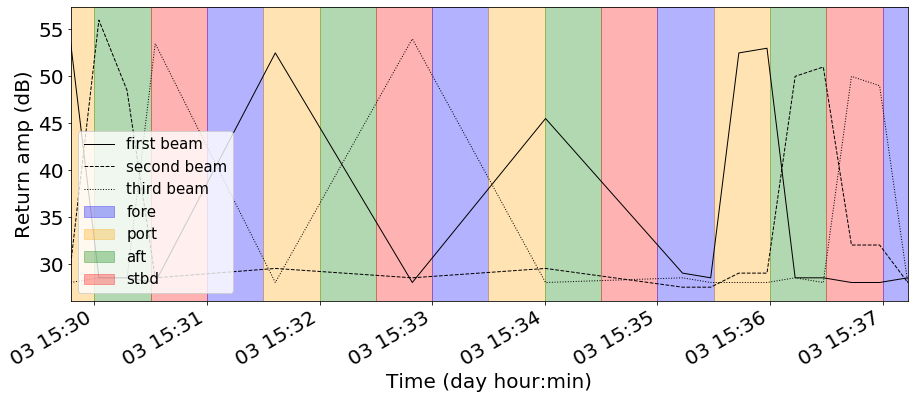

In [83]:
fig, ax = plt.subplots(figsize=(15,6))
ax.plot(dorado_dive.time, dorado_dive.amp_beam[:,1,0], color='k', linestyle='-', label="first beam")
ax.plot(dorado_dive.time, dorado_dive.amp_beam[:,1,1], color='k', linestyle='--', label="second beam")
ax.plot(dorado_dive.time, dorado_dive.amp_beam[:,1,2], color='k', linestyle='dotted', label="third beam")
ax.set(xlim=[dorado_dive.time[0], dorado_dive.time[15]], xlabel='Time (day hour:min)',ylabel='Return amp (dB)')
fig.autofmt_xdate()
beam_shade(ax)
ax.legend(loc=3);
fig.savefig('dorado_dive.png')

From this we can see that the transducer not in use is the fore transducer. This is a dive limb, so not the behaviour we want

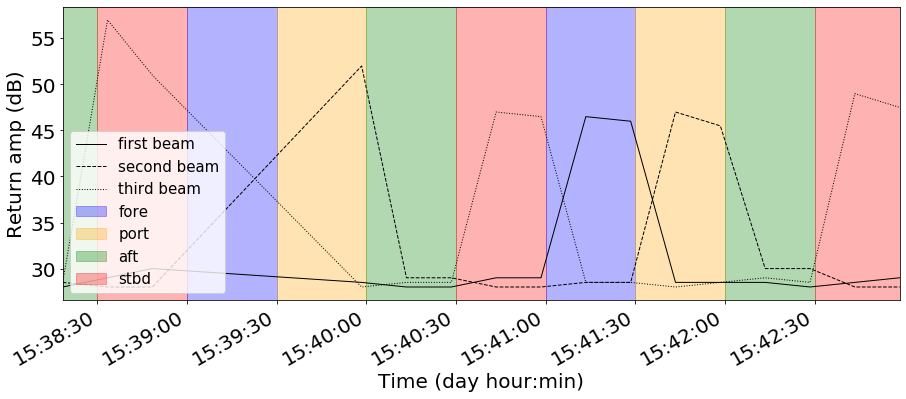

In [84]:
fig, ax = plt.subplots(figsize=(15,6))
ax.plot(dorado_climb.time, dorado_climb.amp_beam[:,1,0], color='k', linestyle='-', label="first beam")
ax.plot(dorado_climb.time, dorado_climb.amp_beam[:,1,1], color='k', linestyle='--', label="second beam")
ax.plot(dorado_climb.time, dorado_climb.amp_beam[:,1,2], color='k', linestyle='dotted', label="third beam")
ax.set(xlim=[dorado_climb.time[0], dorado_climb.time[15]], xlabel='Time (day hour:min)',ylabel='Return amp (dB)')
fig.autofmt_xdate()
beam_shade(ax)
ax.legend(loc=3);
fig.savefig('dorado_climb.png')

On the climb limb, the aft transducer is disabled. Again this is the opposite behaviour to what we want

In [86]:
eagle_overview, eagle_mission_dict = adcp_import_data(eagle_path)
eagle_dive = eagle_mission_dict['0009a']
eagle_climb = eagle_mission_dict['0009b']


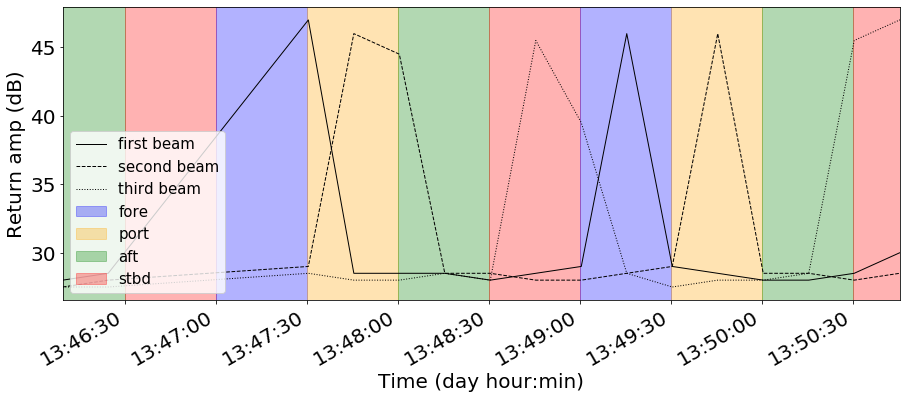

In [87]:
fig, ax = plt.subplots(figsize=(15,6))
ax.plot(eagle_dive.time, eagle_dive.amp_beam[:,1,0], color='k', linestyle='-', label="first beam")
ax.plot(eagle_dive.time, eagle_dive.amp_beam[:,1,1], color='k', linestyle='--', label="second beam")
ax.plot(eagle_dive.time, eagle_dive.amp_beam[:,1,2], color='k', linestyle='dotted', label="third beam")
ax.set(xlim=[eagle_dive.time[0], eagle_dive.time[15]], xlabel='Time (day hour:min)',ylabel='Return amp (dB)')
fig.autofmt_xdate()
beam_shade(ax)
ax.legend(loc=3);
fig.savefig('eagle_dive.png')

In [ ]:
fig, ax = plt.subplots(figsize=(15,6))
ax.plot(eagle_climb.time, eagle_climb.amp_beam[:,1,0], color='k', linestyle='-', label="first beam")
ax.plot(eagle_climb.time, eagle_climb.amp_beam[:,1,1], color='k', linestyle='--', label="second beam")
ax.plot(eagle_climb.time, eagle_climb.amp_beam[:,1,2], color='k', linestyle='dotted', label="third beam")
ax.set(xlim=[eagle_climb.time[0], eagle_climb.time[15]], xlabel='Time (day hour:min)',ylabel='Return amp (dB)')
fig.autofmt_xdate()
beam_shade(ax)
ax.legend(loc=3);
fig.savefig('eagle_climb.png')

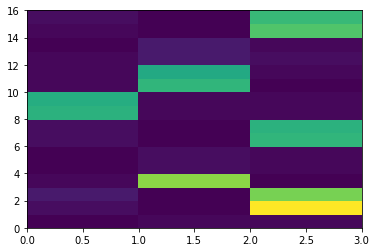

In [15]:
plt.pcolor(bar.amp_beam[:,1,:])

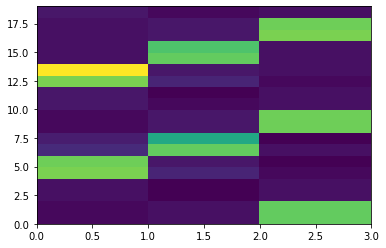

In [16]:
plt.pcolor(foo.amp_beam[:,1,:])